# Multi-Variable Linear Regression
In this document I will explain the code I wrote to attempt to implement a multivariable linear regression algorithm. Ill try my best to explain how multivariable linear regression works.
## Some notation
$ m= $ number of training examples (data entries) 
$ n= $ number of features 
$ y= $ column matirx of outputs 
$ x^{i}= $ matrix of input features of the $ i^{th} $ training example 
$ x^{i}_{j}= $ value of feature j in the ith training example 


In [58]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Dataset
The dataset I used was one from a course on machine learning. It has two features and 47 entries. This dataset is small and that was one of the reasons that I chose it as it will make testing code much quicker. I needed to load the dataset into a format that I could use. I made a function that separated the features and the outputs to two different numpy arrays, and added an extra feature to each entry $ x_0=1 $ which I will get to why in a minute. 

In [59]:
def openCsv(file):
    a = open(file)
    b = [row for row in csv.reader(a)]
    c = [[b[i][-1]] for i in range(len(b))]
    for i in range(len(b)):
        del b[i][-1]
        b[i].insert(0, 1)
    X = np.array(b, dtype=np.float64)
    y = np.array(c, dtype=np.float64)
    return X, y

In [60]:
X, y = openCsv("Data_2.csv")

Basic feature scaling was applied in which each value of a feature gets divided by the largest value of the feature column, so all values would be between 0 and 1. $ x_0 $ did not have this process applied. This makes the training process a lot faster.

In [61]:
X_max = []
for i in range(1, np.size(X, axis=1)):
    if i == 1:
        y_max = np.max(y)
        y /= y_max
    else:
        pass

    X_max.append(np.max(X[:, i]))
    X[:, i] /= X_max[i - 1]

## Hypothesis
The hypothesis function is what is used to make a prediction, letting $ \theta $ be the parameters and $ X $ matrix of a training example's features (including $ x_0 $).
$$
\theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix}
$$
$$
X = \begin{bmatrix} x_0 \\ x_1 \\ \vdots \\ x_n \end{bmatrix}
$$
The function multiplies the transpose of the $ \theta $ matrix and post multiplies it by the matrix $ X $ which leads to a multivariable linear equation.
$$
h_{\theta}(x^i) = \theta^T X = \theta_0 x_0 + \theta_1 x_1 + \cdots + \theta_n x_n
$$
For this to be compatible with feature scaling we first scale all the features by dividing each feature by the max value of all the features. In the begining its one as we have already applied feature scaling so it will divide by one by when we reverse the feature scaling this will scale them back down. It then has the hypothesis function applied, and this result is multiplied by the maximum value of y which will revert the feature scaling. Inititally this is going to be completely wrong, but thats why we train it. \
Since this is a multivariable function plotting is usually not possible as the graph would most likeley be in dimensions higher than the third one. In this case it will be a 3D plot which is possible but I need to figure out how to implement that and learn how to use pyplot a bit better.

In [62]:
thetas = np.abs(np.random.standard_normal((X.shape[-1], 1)))

def hypothethis(data_in):
    p = data_in[1:] / np.max(X[:, 1:], axis=0)
    p = np.insert(p, 0, 1)
    pred = np.dot(thetas.T, p.reshape((len(data_in), 1)))
    return pred * np.max(y)

## Training
The process of training is to make the model fit the data as best as possible by adjusting the parameters. \
Before the model can be trained it must first know how bad it is doing and how it can improve. A cost function is used to meassure its performance. In this case we take the squared error of every training example and take an average of that. It is multiplied by half in the end to make later computation a bit easier.
$$
J(\theta) = \frac{1}{2m} \sum_{i = 1}^{m} \left (h_{\theta}(x^i) - y^i \right)^2
$$
This cost funtion is a multivariable function, but to explain what is going on a very simplyfied graph of the cost function is plotted with only two parameters to show how the process works, but in practice this graph will be in much higher dimensions.

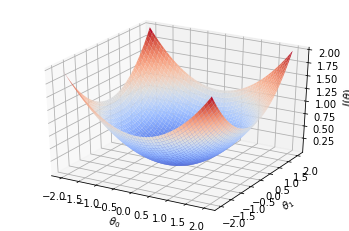

In [63]:
x = np.linspace(-2, 2, num=100)
Y = x
x, Y = np.meshgrid(x, Y)
Z = np.power(x, 2) + np.power(Y, 2)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, Y, Z/4, cmap=cm.coolwarm)
ax.set_xlabel(r"$\theta_0$")
ax.set_ylabel(r"$\theta_1$")
ax.set_zlabel(r"$J(\theta)$")
plt.show()

This graph has a minimum point that represents the parameters which lead to the lowest cost. To get there we need a way to tell the computer what step to take in this graph in order to get as close as possible to the minimum point. We use the partial derivative for each parameter in order to get there. Luckly the partial derivatives are easy to derive. This is the way it works in my program:
$$
\frac{\partial{J(\theta)}}{\partial{\theta_j}} = \frac{1}{m} \sum_{i = 1}^{m} \left (h_{\theta}(x^i) - y^i \right) x_j^i
$$
$$
\frac{\partial{J(\theta)}}{\partial{\theta}} = \begin{bmatrix} \frac{\partial{J(\theta)}}{\partial{\theta_0}} \\ \frac{\partial{J(\theta)}}{\partial{\theta_1}} \\ \vdots \\ \frac{\partial{J(\theta)}}{\partial{\theta_n}} \end{bmatrix}
$$
Essentially it takes the average of the derivatives of all the training example with respect to the first parameters, then it puts it into a matrix and repeates for all the parameters. \
Some may know that it is possible to minimize the funtion explicitly but I will not use that way (its called the normal equation) as I do not fully understand its derivation and I would like to fully understand it before I use it. \
I made a function to calculate the cost and the derivative needed.

In [64]:
def costs(data_in, outputs):
    pred = []
    cost = []
    derivs = []
    for x, y in zip(data_in, outputs):
        pred.append(hypothethis(x))
        c = ((pred[-1] - y)**2)/2
        cost.append(c)
        d = (pred[-1] - y) * x
        derivs.append(d)
    cost = np.average(cost)
    derivs = np.average(derivs, axis=0)
    return cost, derivs.T

To update the parameters we subtract it from the derivative times a constant called the learning rate $ \alpha $ which is important to adjust just right as too high of a value would result in overshooting leading to the model never learning, whereas a too low value would lead to the model taking forever to learn.
$$
\theta_j := \theta_j - \alpha \frac{\partial{J(\theta)}}{\partial{\theta_j}}
$$
Taking the negative makes the computer take steps down the graph instead of upwards. We iterate this for how many times as we want.

In [65]:
def train(data_in, parameters, outputs, iterations=1, alpha=0.1):
    for i in range(iterations):
        cost, derivs = costs(data_in, outputs)
        parameters -= alpha * derivs
    return parameters

In [66]:
thetas = train(X, thetas, y, 1000, 0.2)

Here we scale all the features back.

In [67]:
X[:, 1:] *= X_max
y *= y_max
print(hypothethis(X[1]))

[[288067.3656679]]


In [68]:
y[1]

array([329900.])

Due to the fact that I have used a very basic form of feature scaling that has caused for the error to scale with it, so the model is not entirely accurate. It is very close though so it is learning but the feature scaling needs to be more sophisticated.